# Dissecting Spotify Valence

## Introduction
* Spotify utilizes a metric known as "valence" to assess the emotional content of a track, originally developed by Echo Nest, later acquired by Spotify in 2014. Despite its widespread use, the precise algorithm for valence calculation remains undisclosed. 
* This project aims to leverage Spotify's API features for retrieving track audio features and analysis. 
* The data utilised for the models came from 2 sources: [Kaggle](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db?resource=download) and [Zenodo](https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013). 
* The IDs of the songs contained in the previously mentioned datasets were passed through Spotify's API to acquire their features which were then written in a file called `tracks.csv`. 
* The objective is to employ inferential statistics and machine learning techniques to understand the influence of various track features on valence. 
* The evaluation will be based on a holdout testing dataset using Mean Average Error (MAE) as the ranking metric.

## Importing Libraries

Python's data analysis and visualization ecosystem boasts essential libraries: `pandas` for data manipulation, `numpy` for numerical computing, `scipy.stats` for statistical functions, `statsmodels` for modeling, and `matplotlib.pyplot` and `seaborn` for visualization. These tools collectively enable efficient exploration, analysis, and visualization of data across various scientific domains.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math

import random

import matplotlib.pyplot as plt
import seaborn as sns

## Importing Data

* The file `tracks.csv` contains the features of the songs included in the datasets mentioned in the introduction.
* To make that file, only the unique song IDs were kept and passed through Spotify's API to acquire their features.

In [2]:
tracks = pd.read_csv('tracks.csv')
tracks['mode']=tracks['mode'].astype('category')
tracks['key']=tracks['key'].astype('category')
tracks['time_signature']=tracks['time_signature'].astype('category')
tracks.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4


In [3]:
sample=tracks.sample(5000,random_state=42)

Only the features that describe the songs are kept.

In [4]:
data = tracks[['valence','danceability','energy','loudness','speechiness','acousticness','liveness','tempo','key','mode','duration_ms','time_signature']]
data.describe()

,valence,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms
count,187945.000000,187945.000000,187945.000000,187945.000000,187945.000000,187945.000000,187945.000000,187945.000000,1.879450e+05
mean,0.455012,0.549761,0.563612,-9.913562,0.128887,0.395404,0.221796,117.547498,2.343016e+05
std,0.265387,0.191302,0.271926,6.300906,0.200808,0.361419,0.208395,31.153693,1.273722e+05
min,0.000000,0.000000,0.000020,-52.458000,0.000000,0.000000,0.009670,0.000000,1.538700e+04
25%,0.229000,0.424000,0.362000,-12.457000,0.037100,0.047100,0.097300,92.516000,1.780000e+05
50%,0.446000,0.568000,0.603000,-7.952000,0.050600,0.275000,0.129000,115.527000,2.176670e+05
75%,0.668000,0.693000,0.789000,-5.550000,0.109000,0.772000,0.272000,139.053000,2.656620e+05
max,1.000000,0.989000,0.999000,3.744000,0.967000,0.996000,1.000000,243.372000,5.552917e+06


* The dataset comprises 187,945 entries, each featuring various musical attributes. 
* Among these, the mean valence stands at 0.455 with a standard deviation of 0.265, reflecting the overall positivity of the music. 
* Danceability, averaging at 0.550 with a standard deviation of 0.191, indicates the ease of movement it inspires. 
* Energy levels, with a mean of 0.564 and a standard deviation of 0.272, suggest the vigor and intensity of the tracks. 
* Loudness, averaging at -9.914 dB and ranging from -52.458 dB to 3.744 dB, reflects the volume of the compositions. 
* Speechiness, with a mean of 0.129 and a standard deviation of 0.201, suggests the presence of spoken words.
* Acousticness, averaging 0.395 with a standard deviation of 0.361, indicates the extent to which the music relies on acoustic instruments. 
* Liveness, with a mean of 0.222 and a standard deviation of 0.208, reveals the presence of live audience recordings. 
* Tempo, averaging 117.547 BPM with a standard deviation of 31.154, indicates the speed of the tracks. 

## Histograms of Numeric Variables

<Axes: xlabel='valence', ylabel='Count'>

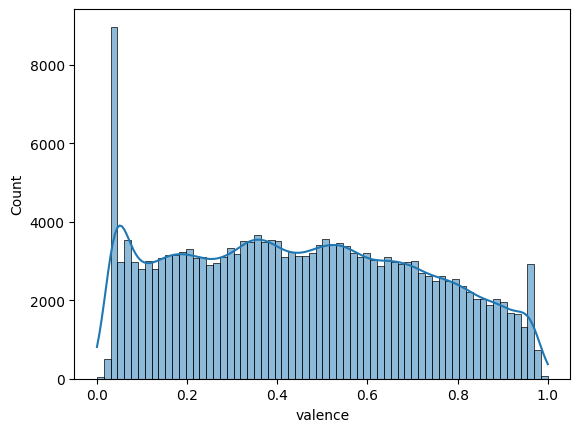

In [5]:
sns.histplot(x='valence',data=data,kde=True)

<Axes: xlabel='danceability', ylabel='Count'>

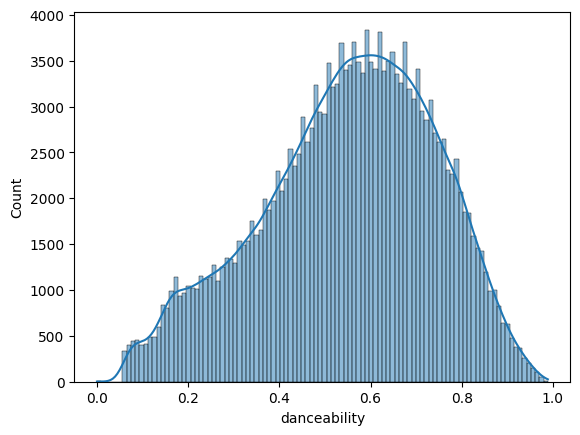

In [6]:
sns.histplot(x='danceability',data=data,kde=True)

<Axes: xlabel='energy', ylabel='Count'>

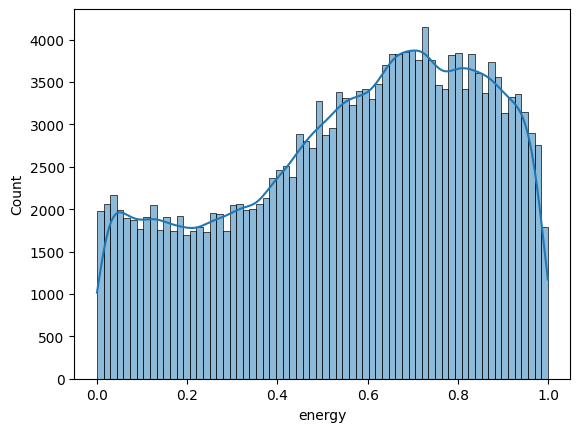

In [7]:
sns.histplot(x='energy',data=data,kde=True)

<Axes: xlabel='loudness', ylabel='Count'>

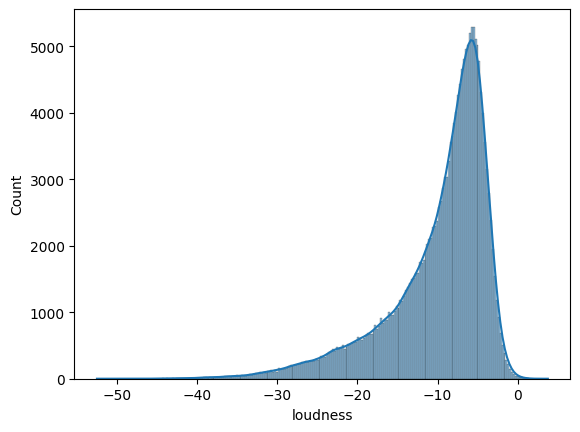

In [8]:
sns.histplot(x='loudness',data=data,kde=True)

<Axes: xlabel='speechiness', ylabel='Count'>

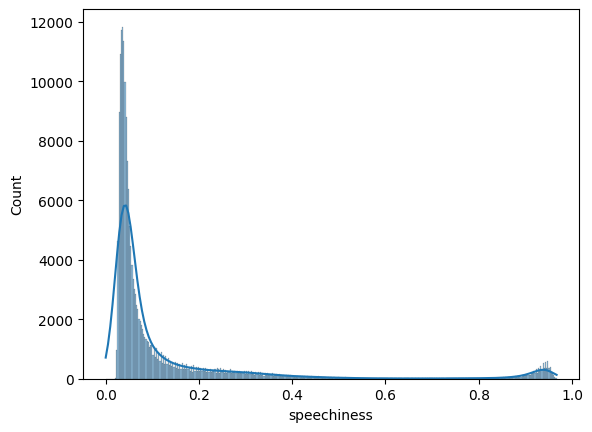

In [9]:
sns.histplot(x='speechiness',data=data,kde=True)

<Axes: xlabel='acousticness', ylabel='Count'>

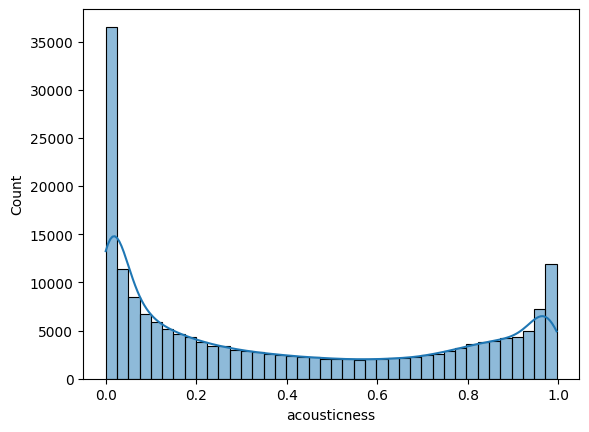

In [10]:
sns.histplot(x='acousticness',data=data,kde=True)

<Axes: xlabel='liveness', ylabel='Count'>

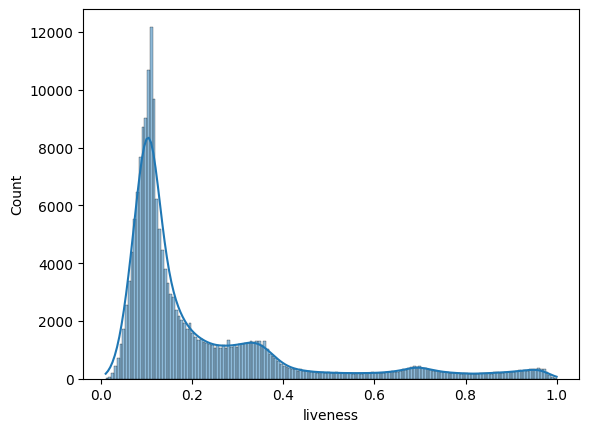

In [11]:
sns.histplot(x='liveness',data=data,kde=True)

<Axes: xlabel='tempo', ylabel='Count'>

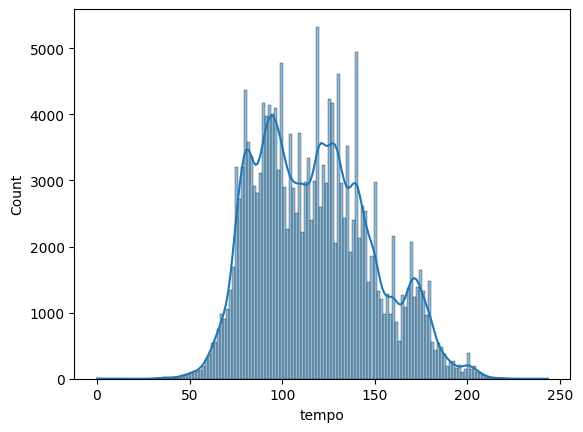

In [12]:
sns.histplot(x='tempo',data=data,kde=True)

<Axes: xlabel='duration_ms', ylabel='Count'>

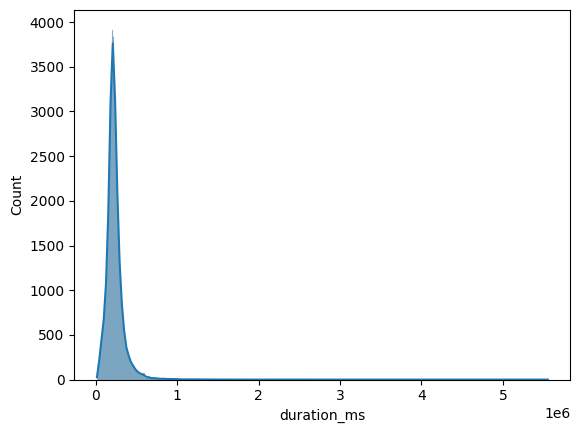

In [13]:
sns.histplot(x='duration_ms',data=data,kde=True)

* The histogramms of the numeric variables show the diversity of the variables, meaning that each one follows its own distribution, way different than Normal.

In [14]:
data_num = data[['valence','danceability','energy','loudness','speechiness','acousticness','liveness','tempo','duration_ms']]

## Correlation

<Axes: >

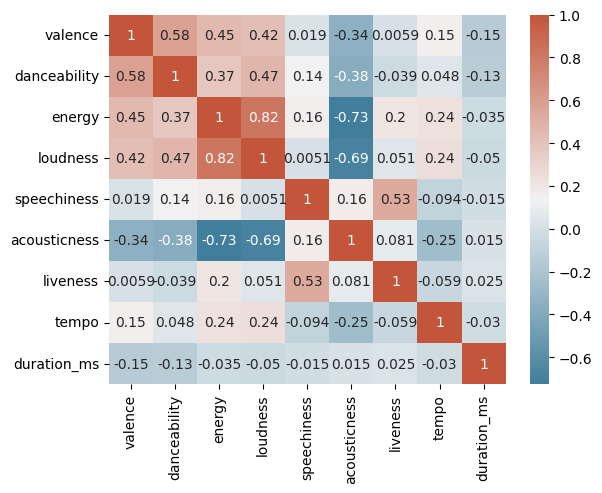

In [15]:
corr = data_num.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,cmap=cmap,annot=True)

* Generally the correlations between valence and the other variables are weak.
* The strongest one is with `danceability` at **0.58** being followed by `energy` and `loudness` at **0.45** and **0.42** .
* So those variables are kept for an explanatory linear model.

## Explanatory Model

In [16]:
model = smf.ols(formula="valence~danceability+energy+loudness",data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 4.152e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:33:21   Log-Likelihood:                 30427.
No. Observations:              187945   AIC:                        -6.085e+04
Df Residuals:                  187941   BIC:                        -6.080e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1373      0.004    -38.254      0.000      -0.144      -0.130
danceability     0.6799      0.003    242.126      0.000       0.674       0.685
energy           0.3277      0.003    106.330      0.000       0.322       0.334
loudness        -0.0034      0.000    -24.402      0.000      -0.004      -0.003
==============================================================================
Omnibus:                      608.130   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.306
Skew:                           0.024   Prob(JB):                    2.75e-103
Kurtosis:                       2.759   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model1 = smf.ols(formula="valence~danceability+energy",data=data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                 6.179e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:33:21   Log-Likelihood:                 30129.
No. Observations:              187945   AIC:                        -6.025e+04
Df Residuals:                  187942   BIC:                        -6.022e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0581      0.002    -37.816      0.000      -0.061      -0.055
danceability     0.6586      0.003    246.399      0.000       0.653       0.664
energy           0.2681      0.002    142.562      0.000       0.264       0.272
==============================================================================
Omnibus:                      755.311   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.804
Skew:                           0.039   Prob(JB):                    1.25e-126
Kurtosis:                       2.740   Cond. No.                         8.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The two models have almost identical R-squared values, so the one with the least variables is kept.
* The Ordinary Least Squares (OLS) regression model results indicate a moderate fit with an **R-squared** value of 0.397, suggesting that approximately 39.7% of the variability in valence can be explained by danceability and energy.
* The `intercept` ***-0.0581*** represents the estimated value of the valence when ***both danceability and energy are zero***. However, it might not have a practical interpretation in this context, as it's unlikely to have songs with zero danceability and energy. 
* The coefficient for `danceability` is ***0.6586***. This means that, holding energy constant, a one-unit increase in danceability is associated with an increase of 0.6586 units in valence. In practical terms, this suggests that songs with higher danceability tend to have higher valence scores.
* The coefficient for `energy` is ***0.2681***. Holding danceability constant, a one-unit increase in energy is associated with an increase of 0.2681 units in valence. This implies that songs with higher energy levels also tend to have higher valence scores.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data[['danceability', 'energy']]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Variable        VIF
0         const  10.451973
1  danceability   1.156398
2        energy   1.156398


* VIF values at 1.15 indicate there is no multicollinearity between the variables.

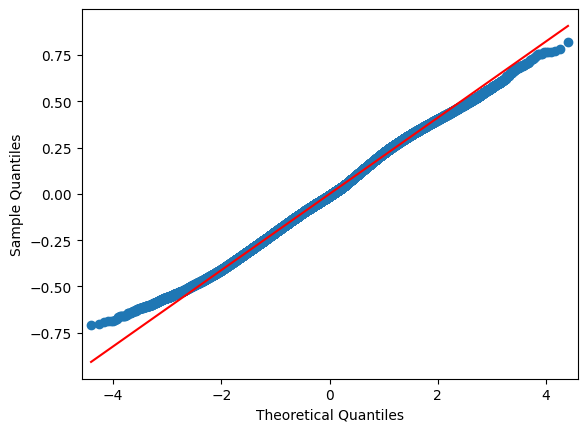

In [19]:
from statsmodels.graphics.gofplots import qqplot

# Q-Q plot
qqplot(model1.resid, line='s')
plt.show()

* The residuals are somewhat normally distributed, however, due to the large size of the dataset, normality is not a problem.

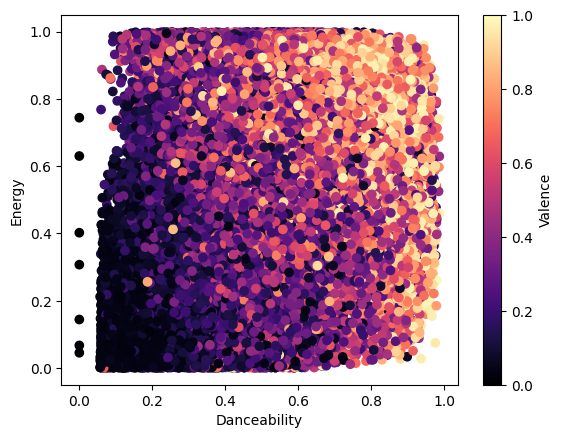

In [20]:
# Create a scatter plot to visualize the relationship between danceability and energy
plt.scatter(data['danceability'], data['energy'], c=data['valence'], cmap='magma')

# Create a colorbar to represent the valence values
cbar = plt.colorbar()
cbar.set_label('Valence')

# Add labels to the axes
plt.xlabel('Danceability')
plt.ylabel('Energy')

# Show the plot
plt.show()

* From the scatter plot of `energy` (Y axis), `danceability` (X axis) and `valence` (colour axis), it is clear that songs with lower valence are located near lower danceability and energy levels and ongs with higher valence are located near higher danceability and energy levels.
* However, one can say that `valence` values are **sparse**, specifically in Y axis, which means that `energy` has a weaker correlation with `valence`.

## Machine Learning

* In this section, the goal is to find the best predictive model for `valence`. 
* The final model is selected based on the lowest mean absolute error (MAE).

***DISCLAIMER***: All the models below are the selected ones after testing lots of hyperparameters. The hyperparameter testings and comparisons are not included in this notebook due to time consumption. 

In [21]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature matrix and target variable, respectively
X=data[['danceability','energy','loudness','speechiness','acousticness','liveness','tempo','key','mode','duration_ms','time_signature']]
y=data['valence']
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# X_train: Features for training
# X_val: Features for validation
# y_train: Target values for training
# y_val: Target values for validation

* The feature matrix (X) consists of key audio features, while the target variable (y) represents the valence of the music tracks. 
* The dataset is split into 80% training data (`X_train`, `y_train`) and 20% validation data (`X_val`, `y_val`). 

### Random Forest

* A Random Forest Regressor was implemented. 
* Hyperparameter tuning was conducted using grid search, 'n_estimators' set to 50 and 'max_depth' set to 50. 
* The best model was selected based on the negative mean absolute error during a 5-fold cross-validation.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define Random Forest model
rf_model = RandomForestRegressor(random_state=0)

# Define hyperparameters grid
param_grid_rf = {
    'n_estimators': [50], 
    'max_depth': [50] 
}

# Perform grid search
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train)

# Get best model
best_rf_model = grid_search_rf.best_estimator_


# Evaluate on validation set
y_pred_rf = best_rf_model.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f'Random Forest MAE: {mae_rf}')



Random Forest MAE: 0.13877755276683024


* MAE achieved by the Random Forest model is approximately **0.1388**.

### Gradient Boosting Regressor

* A Gradient Boosting Regressor was implemented. 
* The model underwent hyperparameter tuning with a grid search, focusing on `n_estimators` (set to 200) and `learning_rate` (set to 0.2). 
* The best model was selected based on the negative mean absolute error during a 5-fold cross-validation. 

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define Gradient Boosting model
gb_model = GradientBoostingRegressor()

# Define hyperparameters grid
param_grid_gb = {
    'n_estimators': [200],
    'learning_rate': [0.2] 
}

# Perform grid search
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='neg_mean_absolute_error')
grid_search_gb.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search_gb.best_estimator_

# Make predictions on the validation dataset using the best Gradient Boosting model
y_pred_gb = best_gb_model.predict(X_val)

# Calculate the Mean Absolute Error (MAE) for the best Gradient Boosting model
mae_gb = mean_absolute_error(y_val, y_pred_gb)

print(f"Gradient Boosting MAE: {mae_gb}")

Gradient Boosting MAE: 0.14139680090488455


* MAE achieved by the Gradient Boosting model is approximately **0.1414**.

### Histogram Gradient Boosting Regressor

* A Histogram Gradient Boosting Regressor was implemented. 
* Hyperparameter tuning was performed using grid search, focusing on `max_iter` (set to 50), `learning_rate` (set to 0.5), `max_depth` (set to 50) and `min_samples_leaf` (set to 50).
* The best model was selected based on the negative mean absolute error during a 5-fold cross-validation.

In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define Histogram Gradient Boosting model
hist_gb_model = HistGradientBoostingRegressor(loss='absolute_error',random_state=0)

# Define hyperparameters grid for HistGradientBoostingRegressor
param_grid_hist_gb = {
    'max_iter': [50],  # Number of boosting iterations
    'learning_rate': [0.5],  # Learning rate
    'max_depth': [50],  # Maximum depth of the individual estimators
    'min_samples_leaf': [50],  # Minimum number of samples per leaf
    'l2_regularization': [0.0]  # L2 regularization parameter
}

# Perform grid search
grid_search_hist_gb = GridSearchCV(hist_gb_model, param_grid_hist_gb, cv=5, scoring='neg_mean_absolute_error')
grid_search_hist_gb.fit(X_train, y_train)

# Get the best model
best_hist_gb_model = grid_search_hist_gb.best_estimator_

# Make predictions on the validation dataset using the best HistGradientBoostingRegressor model
y_pred_hist_gb = best_hist_gb_model.predict(X_val)

# Calculate the Mean Absolute Error (MAE) for the best HistGradientBoostingRegressor model
mae_hist_gb = mean_absolute_error(y_val, y_pred_hist_gb)

print(f"HistGradient Boosting MAE: {mae_hist_gb}")


HistGradient Boosting MAE: 0.14014510077068335


* The Mean Absolute Error (MAE) achieved by the HistGradient Boosting model is approximately **0.1401**.

### KNN

* The final KNN model was trained with **24** neighbors.

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

# Define the k neighbors
k = 24

# Train the final KNN model on the entire training dataset
best_knn_model = KNeighborsRegressor(n_neighbors=k)
best_knn_model.fit(X_train, y_train)

# Make predictions on the test dataset using the final KNN model
y_pred_knn = best_knn_model.predict(X_val)

# Calculate the Mean Absolute Error (MAE) for the final KNN model
mae_knn_final = mean_absolute_error(y_val, y_pred_knn)

print("Mean Absolute Error (KNN Model):", mae_knn_final)

Mean Absolute Error (KNN Model): 0.21978956144084702


* MAE for the final KNN model is approximately 0.2198.

## Comparing ML models based on MAE

In [26]:
from sklearn.metrics import mean_absolute_error

# Dictionary to store model names and their corresponding models
models = {
    "rf": best_rf_model,
    "gb": best_gb_model,
    "knn": best_knn_model,
    "hist_gb":best_hist_gb_model
}

# Dictionary to store model names and their corresponding MAE values
mae_scores = {}

# Iterate over models
for model_name, model in models.items():
    # Predict using the current model
    y_pred = model.predict(X_val)
    # Calculate MAE
    mae = mean_absolute_error(y_val, y_pred)
    # Store MAE in the dictionary
    mae_scores[model_name] = mae

# Print MAE scores for each model
for model_name, mae in mae_scores.items():
    print(f"MAE for {model_name}: {mae}")


MAE for rf: 0.13877755276683024
MAE for gb: 0.14139680090488455
MAE for knn: 0.21978956144084702
MAE for hist_gb: 0.14014510077068335


* Based on MAE scores, the **Random Forest model** achieved the lowest MAE of 0.1388, making it the best-performing model among the options provided.

### Feature Importance

* Lets see the importance of each feature in the selected model.
* Feature importance quantifies the impact of each feature on the model's output. 

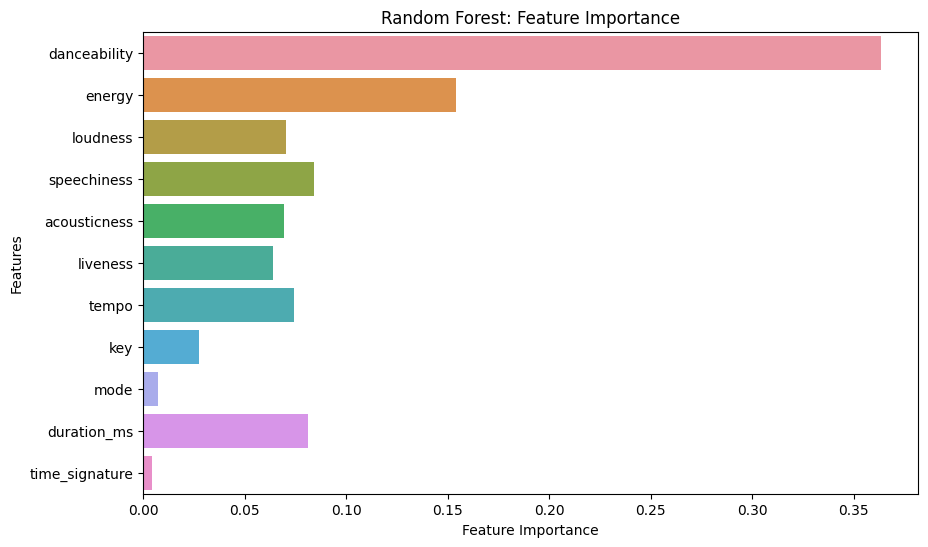

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance Plot
plt.figure(figsize=(10, 6))
feature_importance_rf = best_rf_model.feature_importances_
sns.barplot(x=feature_importance_rf, y=X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest: Feature Importance')
plt.show()


* The most influential features, ranked by their importance scores in the Random Forest model, are `danceability` (36.355%), `energy` (15.397%), `speechiness` (8.434%), `duration_ms` (8.142%), and `tempo` (7.436%).

### Holdout Testing Dataset

* Loading the hold-out dataset.

In [28]:
test_tracks = pd.read_csv('test_tracks.csv')
test_tracks['mode']=test_tracks['mode'].astype('category')
test_tracks['key']=test_tracks['key'].astype('category')
test_tracks['time_signature']=test_tracks['time_signature'].astype('category')
test_tracks.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,6HgWWaMu31KdOpEG5l28BG,0.829,0.436,3,-8.205,1,0.3270,0.150,0.00000,0.0954,0.693,143.031,audio_features,6HgWWaMu31KdOpEG5l28BG,spotify:track:6HgWWaMu31KdOpEG5l28BG,https://api.spotify.com/v1/tracks/6HgWWaMu31Kd...,https://api.spotify.com/v1/audio-analysis/6HgW...,223204,4
1,5wxYxygyHpbgv0EXZuqb9V,0.681,0.821,11,-5.120,0,0.1310,0.532,0.00111,0.0921,0.813,94.074,audio_features,5wxYxygyHpbgv0EXZuqb9V,spotify:track:5wxYxygyHpbgv0EXZuqb9V,https://api.spotify.com/v1/tracks/5wxYxygyHpbg...,https://api.spotify.com/v1/audio-analysis/5wxY...,214701,4
2,24FUBxaAYSBlWsbSnEzDcn,0.647,0.340,2,-8.795,0,0.0496,0.245,0.00000,0.1070,0.176,91.998,audio_features,24FUBxaAYSBlWsbSnEzDcn,spotify:track:24FUBxaAYSBlWsbSnEzDcn,https://api.spotify.com/v1/tracks/24FUBxaAYSBl...,https://api.spotify.com/v1/audio-analysis/24FU...,277721,4
3,5QM0SsyzmBM0pbFY52Xj1X,0.677,0.485,5,-5.795,1,0.0361,0.529,0.00002,0.0766,0.493,82.001,audio_features,5QM0SsyzmBM0pbFY52Xj1X,spotify:track:5QM0SsyzmBM0pbFY52Xj1X,https://api.spotify.com/v1/tracks/5QM0SsyzmBM0...,https://api.spotify.com/v1/audio-analysis/5QM0...,239317,4
4,1ODFVLQszq0hCOdZtqV5wq,0.805,0.612,8,-5.682,0,0.1720,0.188,0.00002,0.1340,0.425,126.013,audio_features,1ODFVLQszq0hCOdZtqV5wq,spotify:track:1ODFVLQszq0hCOdZtqV5wq,https://api.spotify.com/v1/tracks/1ODFVLQszq0h...,https://api.spotify.com/v1/audio-analysis/1ODF...,189259,4


In [29]:
test_data = test_tracks[['valence','danceability','energy','loudness','speechiness','acousticness','liveness','tempo','key','mode','duration_ms','time_signature']]
test_data.describe()

,valence,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,duration_ms
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,0.515643,0.658244,0.637865,-6.473359,0.088750,0.283009,0.186817,122.058226,200476.131890
std,0.238723,0.143193,0.175190,2.784578,0.089724,0.267065,0.144095,28.062679,51613.593752
min,0.038500,0.234000,0.091100,-22.507000,0.023200,0.000008,0.023200,46.718000,36227.000000
25%,0.331750,0.557750,0.525750,-7.858250,0.038000,0.060000,0.098150,99.995500,167966.000000
50%,0.509000,0.666500,0.655000,-5.953500,0.053300,0.186000,0.126000,121.018000,195638.000000
75%,0.701250,0.774000,0.779000,-4.614500,0.090025,0.458250,0.234500,140.029500,229289.750000
max,0.978000,0.957000,0.988000,0.963000,0.637000,0.994000,0.958000,205.945000,641941.000000


### Final Evaluation

* In this section, the selected model will be evaluated using the hold-out dataset.

In [30]:
X_test=test_data[['danceability','energy','loudness','speechiness','acousticness','liveness','tempo','key','mode','duration_ms','time_signature']]
y_test=test_data['valence']

In [31]:
from sklearn.metrics import mean_absolute_error

# Predict using the current model
y_pred = best_rf_model.predict(X_test)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE for 'Random Forest Model': {mae}")


MAE for 'Random Forest Model': 0.1443729527559055


* MAE for the Random Forest model on the hold-out dataser is approximately 0.1444.